In [2]:
from skimage import feature, color, filters, measure, io
import cv2
import numpy as np
from scipy.ndimage import distance_transform_edt

import matplotlib.pyplot as plt
from scipy import ndimage as nd
from skimage.color import label2rgb
import pandas as pd

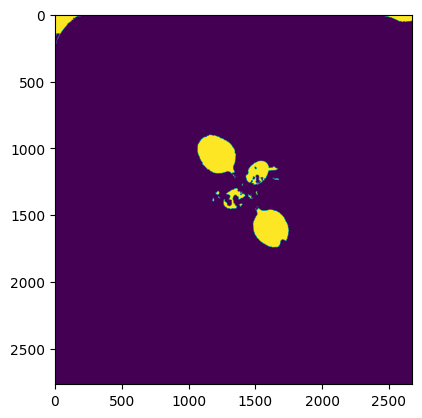

In [5]:
#Image path
img=io.imread('/home/mcaroulle/Pheno_Leaf/Data/Cropped/1.png')
#plt.imshow(img)

##convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask= cv2.inRange(hsv,(30,20,150),(70,255,255))

closed_mask = nd.binary_closing(mask, np. ones ((7,7)))
plt.imshow(closed_mask)
label_image= measure.label(closed_mask)

image_label_overlay = label2rgb(label_image, image= img)
#plt.imshow(image_label_overlay)

props = measure.regionprops_table(label_image, img, 
                                  properties=['label','area','centroid','coords'])

df = pd.DataFrame(props)
#print(df.head())

### Remove border artefacts

In [4]:
from skimage import segmentation

# remove artifacts connected to image border
cleared_label_image = segmentation.clear_border(label_image)

#take measurements 
props = measure.regionprops_table(cleared_label_image, img,
                                  properties=['label', 'area', 'centroid','coords'])

# Convert props to DataFrame
df = pd.DataFrame(props)

### Filtering by area

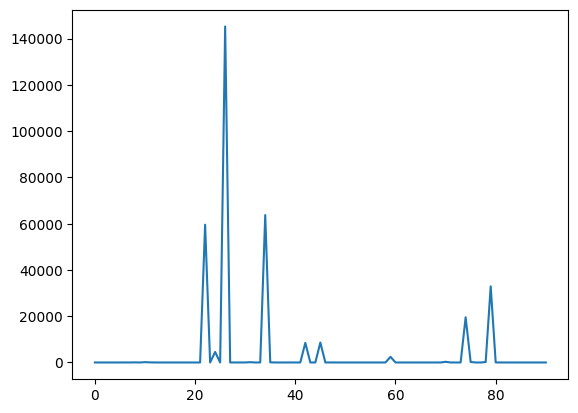

In [5]:
area = df['area']
plt.plot(area)
plt.show()

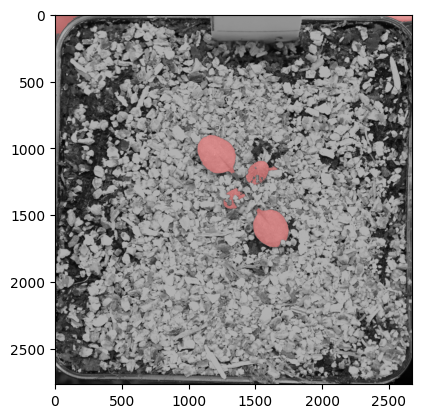

In [7]:
# Filter regions with area less than 5,000
df_filtered = df[df['area'] > 9000]

# Filter label_image based on the filtered DataFrame
filtered_label_image = np.isin(cleared_label_image , df_filtered['label'])


image_label_overlay = label2rgb(filtered_label_image, image= img)
plt.imshow(image_label_overlay)

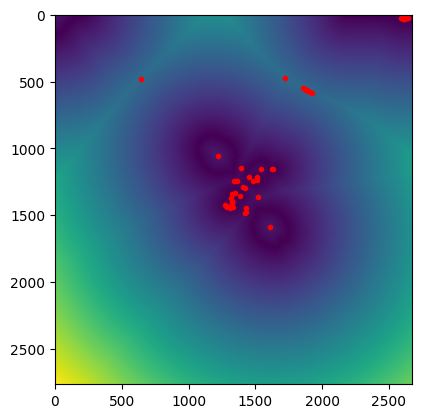

In [14]:
###On définit une fonction qui permet de convertir un masque en une image
def convertir_masque_en_image(mask):
    # Créer une image vide avec les mêmes dimensions que le masque
    image = np.zeros_like(mask)

    # Appliquer le masque à l'image en définissant les pixels blancs
    image[mask > 0] = 255

    # Enregistrer l'image
    return image

image = convertir_masque_en_image(filtered_label_image)

edges = feature.canny(image, sigma=10)

dt = distance_transform_edt(~edges)

local_max = feature.peak_local_max(dt, min_distance=5)

peak_idx = feature.peak_local_max(dt, min_distance=5)

plt.plot(peak_idx[:,1],peak_idx[:,0],'r.')
plt.imshow(dt)

# Creating plants by merging leaves

#### Generate a dataframe with peaks coords

In [15]:
df_peak = pd.DataFrame(peak_idx)
df_peak.columns=['x_coord','y_coord']
df_peak['index_of_label_in_df_coords']=''
df_peak['label']=''

#### Generate a dataframe with label coords

In [16]:
df_filtered_reinit=df_filtered.reset_index(drop=True) #reset of indexes

df_coords=df_filtered_reinit[['label','coords']]

In [17]:

for k in range(len(df_coords)): 
    
    data_coords = df_coords['coords'][k] #array
    coords = data_coords.tolist() #list of list
    x_coords = [sous_liste[0] for sous_liste in coords] #list
    y_coords = [sous_liste[1] for sous_liste in coords] #list 

    # Parcourir les lignes du dataframe
    for index, row in df_peak.iterrows():
        if row['x_coord'] in x_coords and row['y_coord'] in y_coords:
            df_peak.at[index, 'index_of_label_in_df_coords'] = k
        
#Nettoyage du dataframe obtenu
df_peak = df_peak[df_peak['index_of_label_in_df_coords'] != '']

# Recherche des valeurs en double dans la colonne 3
valeurs_en_double = df_peak[df_peak.duplicated(subset='index_of_label_in_df_coords', keep=False)]['index_of_label_in_df_coords'].unique()

# Suppression des lignes en double, sauf la première occurrence
df_peak = df_peak.drop_duplicates(subset='index_of_label_in_df_coords', keep='first')

    

In [18]:
for k in df_peak['index_of_label_in_df_coords']: 
    # Extraction de l'élément de la colonne1 à partir de l'indice
    element = df_coords.loc[k, 'label']

    # Retrouver l'index de la ligne contenant l'élément dans la colonne 3
    index = df_peak.loc[df_peak['index_of_label_in_df_coords'] == k].index[0]

    # Ajouter l'élément dans la ligne donnée de la colonne 3
    df_peak.at[index, 'label'] = element

#### Clean the initial dataframe by removing all objects that are not leaves

In [19]:
df_peak_label=pd.merge(df_filtered_reinit, df_peak, on='label', how='inner')
df_peak_label = df_peak_label.rename(columns={'x_coord' : 'y_coord' , 'y_coord' : 'x_coord'})


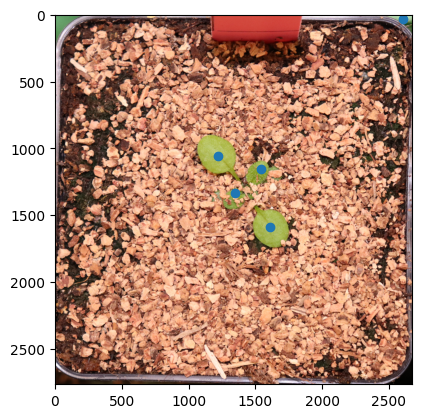

In [20]:
x = df_peak_label['x_coord']
y = df_peak_label['y_coord']
plt.imshow(img)
plt.scatter(x,y)
plt.show()

### on cree un fonction pour fusionner les labels

0
1


2
3


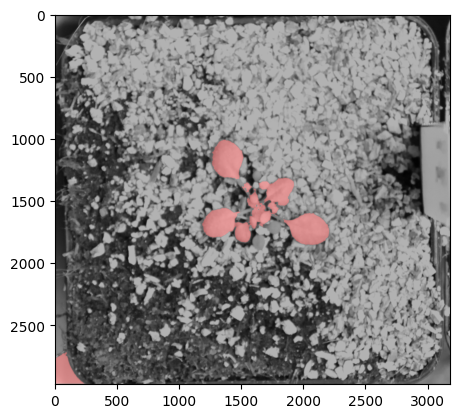

In [14]:
Labels = df_peak_label['label'].tolist()
for k in range (len(Labels)):
    print(k)
    globals()[f'masque_label{k+1}'] = np.where(label_image == Labels[k],255,0).astype(np.uint8)
    if k == 0:
        pass
    elif k == 1 :
        masquefusione = np.logical_or(globals()[f'masque_label{k}'],globals()[f'masque_label{k+1}'])
    else:
        masquefusione = np.logical_or(masquefusione,globals()[f'masque_label{k+1}'])


#plt.imshow(masquefusione)

image_label_overlay = label2rgb(masquefusione, image= img)
plt.imshow(image_label_overlay)
